In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import os
from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import ToCategorical, cutOut


Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
def convLayer(inp,nbrLayer,channel,activation="selu"):
    assert nbrLayer > 0, "In Function convLayer nbrLayer > 0 ?"
    layer = Conv2D(channel, kernel_size=(3, 3), padding="same") (inp)
    layer = Activation(activation)(layer)
    layer = BatchNormalization()(layer)
    
    for i in range(1,nbrLayer):
        layer = Conv2D(channel, kernel_size=(3, 3), padding="same")  (layer)
        layer = Activation(activation)(layer)
        layer = BatchNormalization()(layer)
    return layer

#def FullUnetLoop(input_shape,down_channels=[64,128,256,512,1024],downLayer=2,activation="relu"):

def FullUnetLoopZero(input_shape,down_channels=[64,128,256,512],downLayer=2,activation="relu"):

    def zeroInflatedPoisson(output):
        rate = tf.math.exp(output[:,:,:,0:1]) #A 
        s = tf.math.sigmoid(output[:,:,:,1:2])
        
        pos = tfp.distributions.Poisson(rate=rate)
        det = tfp.distributions.Deterministic(loc=tf.zeros_like(rate))
        components = [det,pos]
        mixture = tfd.Mixture(
              cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
              components=components)
        return tfp.distributions.Independent(mixture,reinterpreted_batch_ndims=1,name="ZeroInflated")
        #return mixture
    
    inputs = Input(shape=input_shape)
    
    layer = Conv2D(down_channels[0], kernel_size=(3, 3), padding="same") (inputs)
    layer = Activation(activation)(layer)
    layer = BatchNormalization()(layer)
    
    layer = Conv2D(down_channels[0], kernel_size=(3, 3), padding="same") (layer)
    layer = Activation(activation)(layer)
    firstLayer = BatchNormalization()(layer)
    
    pool  = MaxPooling2D((2, 2), strides=(2, 2))(firstLayer)
    
    layerArray = []
    
    for channel in down_channels[1:]:
        
        layer = convLayer(pool,downLayer,channel)
       
        if channel != down_channels[-1]:
            layerArray.append(layer)
            pool  = MaxPooling2D((2, 2), strides=(2, 2))(layer)
            
    for i,channel in enumerate(reversed(down_channels[:-1])):
        
        layer = Conv2DTranspose(channel,(3, 3),strides=(2,2),padding="same")(layer)
        layer = Activation(activation)(layer)
        layer = BatchNormalization() (layer)
        
        if len(layerArray) >= (i+1):
            layer = concatenate([layerArray[-(i+1)], layer], axis=3)
        else:
            layer = concatenate([firstLayer, layer], axis=3)
        
        layer = convLayer(layer,downLayer,channel)
        
    output = Conv2D(1, kernel_size=(7, 7), padding="same",activation="selu") (layer)
    #layer = Conv2D(64, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(64, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(32, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(32, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(32, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(32, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(32, kernel_size=(7, 7),activation="selu") (layer)
    #layer = Conv2D(16, kernel_size=(5, 5),activation="selu") (layer)
    #layer = Conv2D(16, kernel_size=(5, 5),activation="selu") (layer)
    #layer = Conv2D(16, kernel_size=(5, 5),activation="selu") (layer)
    #output = Conv2D(16, kernel_size=(5, 5),activation="selu") (layer)
    #layer = Conv2D(8, kernel_size=(3, 3),activation="selu") (layer)
    #output = Conv2D(1, kernel_size=(3, 3),activation="selu") (layer)
    #layer = Activation(tf.math.exp)(layer)
    #layer = Activation("softmax")(output)
    #output = Activation("selu")(output)
    #output = Activation(tf.math.softplus)(output)

    
    output = Flatten()(output)
    #output = Dense(1000)(output)
    #output = Activation("sigmoid")(output)
    #output = tf.keras.layers.Dropout(0.25)(output)
    output = Dense(4096)(output)
    output = Activation(tf.math.softplus)(output)
    #output = tfp.layers.DistributionLambda(zeroInflatedPoisson,name="ZPoisson")(output)
    output = tfp.layers.IndependentPoisson((64,64,1))(output)
    
    model = Model(inputs=inputs, outputs=output)
    return model

In [3]:
dimension = (64,64)
batch_size = 150
channels = 6
optimizer = Adam( lr = 1e-3 )
slices = [256,320,256,320]
cutOutFrame = cutOut(slices)

categorical_list = [0,1,5,10,15,30,60,120]
categorical = ToCategorical(categorical_list)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
#TRANSFORMATIONS = [categorical]
TRANSFORMATIONS = None

def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)


def provideData(flatten=False,dimension=dimension,batch_size=60,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          transform=TRANSFORMATIONS,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)



Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [4]:
t = Trainer(FullUnetLoopZero,
                    NLL,
                    (train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))

[Load file failed]  ./model_data/FullUnetLoopZero_function/FullUnetLoopZero_function64x64x6.h5
[Load file failed]  ./model_data/FullUnetLoopZero_function/FullUnetLoopZero_function64x64x6history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3520        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           conv2d[0][0]                     
_____________________________________________________________________________________________

In [5]:

#m = t.model
#print(m.get_layer('ZPoisson').output)

#x,y = train[0]
#print(m(x).shape)
#print(x.shape)

t.fit(20)

Epoch 1/20
525/525 [==============================] - 227s 433ms/step - loss: 4199.5918 - mse: 361.8376 - mae: 1.0258 - val_loss: 4095.2104 - val_mse: 2.0020 - val_mae: 1.0005
Epoch 2/20
525/525 [==============================] - 225s 429ms/step - loss: 4090.8730 - mse: 1.9950 - mae: 0.9993 - val_loss: 4088.9377 - val_mse: 1.9935 - val_mae: 0.9991
Epoch 3/20
525/525 [==============================] - 223s 424ms/step - loss: 4090.8491 - mse: 1.9948 - mae: 0.9992 - val_loss: 4088.8840 - val_mse: 1.9932 - val_mae: 0.9990
Epoch 4/20
525/525 [==============================] - 223s 425ms/step - loss: 4090.8376 - mse: 1.9952 - mae: 0.9993 - val_loss: 4088.8101 - val_mse: 1.9931 - val_mae: 0.9990
Epoch 5/20
525/525 [==============================] - 225s 429ms/step - loss: 4090.8572 - mse: 1.9948 - mae: 0.9992 - val_loss: 4088.8428 - val_mse: 1.9932 - val_mae: 0.9990
Epoch 6/20
525/525 [==============================] - 224s 426ms/step - loss: 4090.8491 - mse: 1.9945 - mae: 0.9992 - val_loss: 

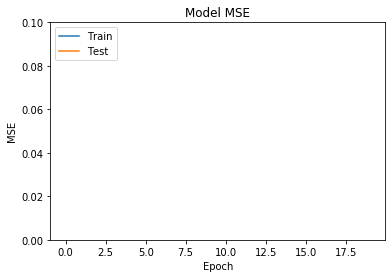

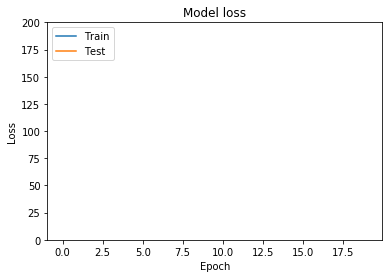

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.ylim(0,0.1)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.ylim(0,200)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [11]:
model = t.model
pred = None
label = None
for x,y in train:
    if y.max() > 0:
        pred = model(x).mean()
        label = y
        break

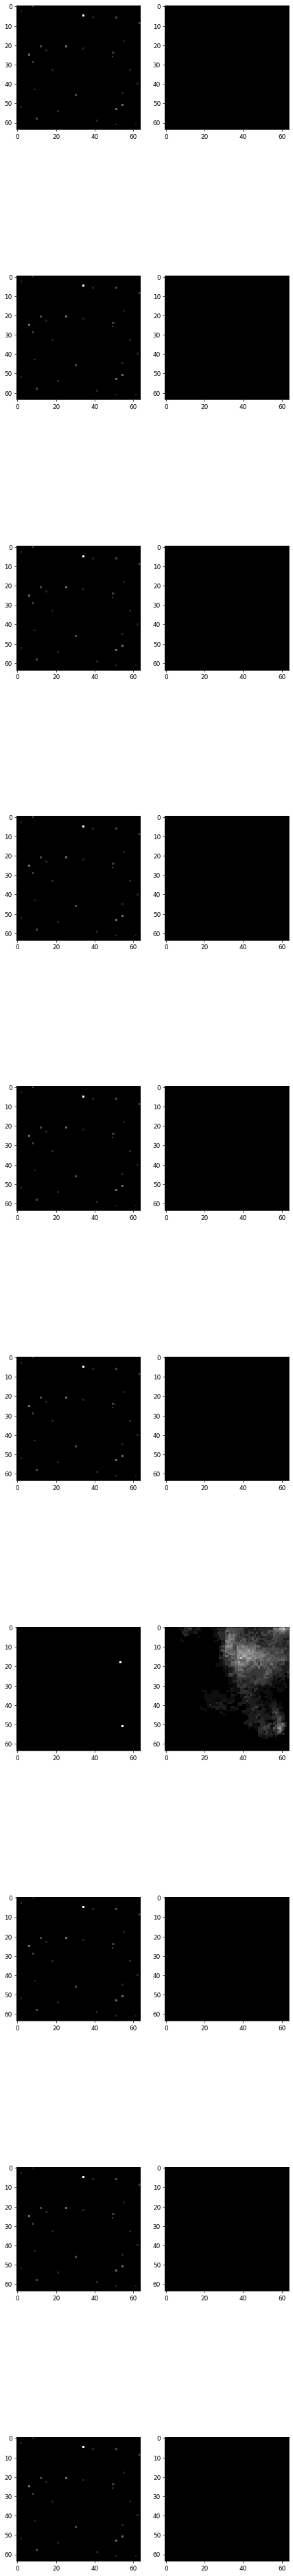

In [12]:
fig, axes = plt.subplots(10, 2, figsize=(8,8*10),dpi=64)

for batch,img in enumerate(pred):
    if batch == 10:
        break
    axes[batch,0].imshow(img[:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch,:,:,0],cmap="gray")